# Modules, functions

In [1]:
import numpy as np
import pandas as pd
import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 800)

import scipy

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend

import datetime as dt

Loading BokehJS ...

In [2]:
def initialize_parameters(par = np.array([0.5, 0.9, 0, 1, 0])):
    # np.random.seed(3)
    parameters = {}

    parameters['alpha'] = par[0]
    parameters['beta'] = par[1]
    parameters['omega'] = par[2]* (1-par[1])    # one way to choose that is omega/(1-beta) = unconditional mean 
    parameters['sigma'] = par[3]
    parameters['f0'] = par[4]                   # one way to choose is unconditional mean 

    return parameters

def loglik(y, f, x, sigma):
    ll = -1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - x*f)**2 
    return ll


def score_compute(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f)/sigma
    # score = (y - x*f)
    
    return score

def filterGAS(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m
        
#     else:
#         loglik_res=10**9 # causing gradient problems??

    return loglik_res

# ----------------------------------------------------------------

def score_compute_2(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f) # ** The 'type = 2' modification **
    
    return score

def filterGAS_2(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute_2(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute_2(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest_2(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS_2(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m
        
#     else:
#         loglik_res=10**9 # causing gradient problems??

    return loglik_res

# ----------------------------------------------------------------

def GAS_est(df):
    
    y = df.net_qty.values          # observed demand (response)
    x = df.buy_availability.values # buy_availability (explanatory)

    y = y.reshape((len(y),1)) 
    x = x.reshape((len(y),1))
    
    ret = pd.DataFrame()
    ret['year'] = df['year']
    ret['week'] = df['week']
        
    abc = scipy.optimize.minimize(
        loglikest,                                       # function to minimize (log likelihood y|x,theta)
        np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]), # initial parameter values (starting)
        args=(y, x), 
        options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
        method='L-BFGS-B', 
        bounds=((0,  None),             # alpha
                (-1, 1),                # beta
                (0.001, np.mean(y)*2),  # omega 
                (0.001, None),          # sigma
                (0.001, np.mean(y)*2)   # f
               )
    )
    
    
    # --- CONVERGENCE control flow ---
    if abc.success == True:
        
        x1par = initialize_parameters(abc.x) 
        GAS = filterGAS(y, x, x1par)
        
        ret['GAS_est'] = GAS
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['One'] * len(y)
        
    # **Modification if first algorithm fails
    elif abc.success == False:
        
        abc = scipy.optimize.minimize(
            loglikest_2,                                       # function to minimize (log likelihood y|x,theta)
            np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]),   # initial parameter values (starting)
            args=(y, x), 
            options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
            method='L-BFGS-B', 
            bounds=((0,  None),             # alpha
                    (-1, 1),                # beta
                    (0.001, np.mean(y)*2),  # omega 
                    (0.001, None),          # sigma
                    (0.001, np.mean(y)*2)   # f
                   )
                )

        x1par = initialize_parameters(abc.x) 
        GAS = filterGAS_2(y, x, x1par)
        
        ret['GAS_est'] = GAS
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['Two'] * len(y)

    return ret

# Data

In [ ]:
# ---- adidas ----
rma1_adi = pd.read_csv('data/article_range_rma1_adidas_fw20.csv', low_memory = False, error_bad_lines = False, sep = ",",
                      usecols = ['Article Number', 'Market Retail Price', 'WE eCom', 'eCom Range'])
rma1_adi = rma1_adi[rma1_adi['eCom Range'] == 'YES']

# ---- reebok ----
rma1_rbk = pd.read_csv('data/article_range_rma1_reebok_fw20.csv', low_memory = False, error_bad_lines = False, sep = ",",
                       usecols = ['Article_number', 'Total Marketing Forecast', '  Total Net Sales  ', '  Total Inline Forecast  ']) # rma1_rbk.columns[40:]

# ----- Buyer reference data (by season) -----
buyer_table = pd.read_csv('data/Buyers Predictions.csv', low_memory = False, error_bad_lines = False, sep = ",")
buyer_table = buyer_table[(buyer_table.season == 'FW19')]

# ----- carryovers -----

carryovers = set(buyer_table.article).intersection(set(rma1_adi['Article Number'])).union(set(buyer_table.article).intersection(set(rma1_rbk.Article_number)))
len(carryovers)

# ----- adidas -----
adi_carryovers = set(buyer_table.article).intersection(set(rma1_adi['Article Number']))
adi_carryovers = pd.DataFrame(data = list(adi_carryovers), columns = ['article_number'])
# adi_carryovers.to_csv("adi_FW20_carryovers.csv", sep=',', encoding='utf-8')

# ----- reebok -----
rbk_carryovers = set(buyer_table.article).intersection(set(rma1_rbk.Article_number))
rbk_carryovers = pd.DataFrame(data = list(rbk_carryovers), columns = ['article_number'])
# rbk_carryovers.to_csv("rbk_FW20_carryovers.csv", sep=',', encoding='utf-8')




In [40]:
dat0 = pd.read_csv('data/ch4k_df_eu.csv')
ref_dat0 = pd.read_csv('data/Article reference data.csv', low_memory = False, error_bad_lines = False, 
                       usecols = ['article_no', 'model_no', 'art_desc', 'sports_cat_desc', 'rmh_cat_desc', 
                                  'franchise', 'gender_desc', 'age_group_desc', 'prod_grp_desc', 'prod_type_desc'])

In [ ]:
# --- NA EDA ---

pd.crosstab(index = dat0[dat0.season == 'FW19'].week, columns = 'count')

len(dat0.article_number.unique())
len(carryovers)

nas = dat0[pd.isnull(dat0).any(axis=1)]
nas.shape # rows w/ NA
nas.isna().sum() # NAs per column

# Articles w/ >= 1 NA
na_ba = nas[nas.buy_availability.isna()].article_number.unique()
len(na_ba)

nas[nas.buy_availability.isna()]

# GAS

In [29]:
dat_GAS = dat0.copy()[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 'buy_availability']]

In [30]:
dat_GAS = dat_GAS[(dat_GAS.season == 'FW19') & (dat_GAS.article_number.isin(carryovers))].sort_values(['article_number', 'country', 'year', 'week'])
# ((dat_GAS.year != 2019) | (dat_GAS.week < 18))] # to simulate partial season

len(dat_GAS.article_number.unique())
dat_GAS.head()

854

,article_number,year,week,country,season,net_qty,buy_availability
2603355,218977,2019,22,EU,FW19,2,0.69
2603455,218977,2019,23,EU,FW19,10,0.69
2603556,218977,2019,24,EU,FW19,7,0.69
2603505,218977,2019,25,EU,FW19,14,0.59
2603413,218977,2019,26,EU,FW19,12,0.79


In [31]:
%%time

# dat_GAS_a = np.random.choice(dat_GAS.article_number.unique(), size = 100, replace = False)
# dat_GAS = dat_GAS[dat_GAS.article_number.isin(dat_GAS_a)]

dat_GAS = dat_GAS.groupby(['article_number', 'country']).apply(GAS_est).reset_index()
dat_GAS = pd.DataFrame(dat_GAS.groupby(['article_number', 'year', 'week'])['GAS_est'].sum()).reset_index()


CPU times: user 2min 23s, sys: 739 ms, total: 2min 23s
Wall time: 2min 32s


In [33]:
dat_GAS

,article_number,year,week,GAS_est
0,218977,2019,22,8.714286
1,218977,2019,23,9.304000
2,218977,2019,24,13.081456
3,218977,2019,25,12.206413
4,218977,2019,26,18.363729
5,218977,2019,27,16.781753
6,218977,2019,28,12.258848
7,218977,2019,29,9.406251
8,218977,2019,30,16.320928
9,218977,2019,31,16.212382


# Seasonality

In [98]:
seasonality_dat = (dat0.
                   copy()[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc']].
                   dropna().
                   sort_values(['article_number', 'year', 'week'])
                  )
seasonality_dat.shape



(4430206, 12)

In [99]:
# ---- Sum over UK/EU, ADD article reference data

seasonality_dat = pd.merge(
    pd.DataFrame(seasonality_dat.groupby(['article_number', 'season', 'year', 'week'])['net_qty'].sum()).reset_index(), # sum over UK & EU
    seasonality_dat[['article_number', 'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc']].drop_duplicates() # add reference information
    ).dropna().sort_values(['article_number', 'year', 'week'])




In [100]:
seasonality_dat = seasonality_dat[~seasonality_dat.season.isin(['FW14',  'FW15', 'SS14','SS15', 'SS16', 'SS17', 'SS18', 'SS19'])]




In [86]:
# seasonality_dat
seasonality_dat.groupby('season')['net_qty'].describe()

# pd.crosstab(index = [seasonality_dat.season, seasonality_dat.week], columns = 'count')


,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
FW16,332184.0,13.948179,49.600511,-3.0,2.0,5.0,13.0,11785.0
FW17,331539.0,18.546415,164.156540,-2.0,2.0,6.0,16.0,83958.0
FW18,341658.0,22.491822,368.104059,-1.0,2.0,6.0,18.0,203727.0
FW19,211735.0,19.468246,88.277670,-3.0,1.0,5.0,17.0,20577.0
SS16,264534.0,12.432459,44.484861,-4.0,2.0,4.0,11.0,5202.0
SS17,275352.0,18.821585,93.183626,-4.0,2.0,6.0,16.0,34206.0
SS18,345705.0,17.476979,155.377441,-4.0,2.0,6.0,15.0,80052.0
SS19,366908.0,21.008266,115.835275,-2.0,2.0,6.0,18.0,43739.0


In [101]:
# ---- Calculate cat-level weekly means across *ALL SEASONS* ---- 

seasonality_sport   = pd.DataFrame(seasonality_dat.groupby(['sports_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'sport_weekly_mean'})
seasonality_rmh     = pd.DataFrame(seasonality_dat.groupby(['rmh_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'rmh_weekly_mean'})
seasonality_gndr    = pd.DataFrame(seasonality_dat.groupby(['gender_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'gender_weekly_mean'})
seasonality_agegrp  = pd.DataFrame(seasonality_dat.groupby(['age_group_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'age_weekly_mean'})
seasonality_frnchse = pd.DataFrame(seasonality_dat.groupby(['franchise', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'franchise_weekly_mean'})
seasonality_prdgrp  = pd.DataFrame(seasonality_dat.groupby(['prod_grp_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'prd_grp_weekly_mean'})

seasonality_dfs = [seasonality_sport, seasonality_rmh, seasonality_gndr, seasonality_agegrp, seasonality_frnchse, seasonality_prdgrp]



In [308]:
def regress(df):
    # function for regressing article net_qty on seasonalities
    # for article a's level of each category, retreive weekly means, then regress 
    
    df = df.sort_values(['article_number', 'year', 'week'])
        
    # article net_demand_qty
    y = df[['net_qty', 'week']].set_index('week')

    # article category-level weekly means; set_index() for joining
    x_sport   = seasonality_sport[seasonality_sport.sports_cat_desc == df.sports_cat_desc.unique()[0]].set_index('week')
    x_rmh     = seasonality_rmh[seasonality_rmh.rmh_cat_desc == df.rmh_cat_desc.unique()[0]].set_index('week')
    x_gndr    = seasonality_gndr[seasonality_gndr.gender_desc == df.gender_desc.unique()[0]].set_index('week')
    x_agegrp  = seasonality_agegrp[seasonality_agegrp.age_group_desc == df.age_group_desc.unique()[0]].set_index('week')
    x_frnchse = seasonality_frnchse[seasonality_frnchse.franchise == df.franchise.unique()[0]].set_index('week')
    x_prdgrp  = seasonality_prdgrp[seasonality_prdgrp.prod_grp_desc == df.prod_grp_desc.unique()[0]].set_index('week')

    # design matrix (ensure 'week' alignment)
    yX = (pd.merge(y, x_sport, left_index=True, right_index=True, how = 'outer').
          merge(x_rmh, left_index=True, right_index=True, how = 'outer').
          merge(x_gndr, left_index=True, right_index=True, how = 'outer').
          merge(x_agegrp, left_index=True, right_index=True, how = 'outer').
          merge(x_frnchse, left_index=True, right_index=True, how = 'outer').
          merge(x_prdgrp, left_index=True, right_index=True, how = 'outer').
          drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
               'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))

    # predict article 'a' net_demand_qty with 5 article 'a' category-level seasonalities
    # print(df.article_number.unique())

    yX = yX.drop('net_qty', axis = 1)
    yX = sm.add_constant(yX)
    
    mod = sm.OLS(yX.net_qty, yX, missing='drop').fit()
    # print(df.article_number.unique(), round(mod.rsquared, 2))

    ret = pd.DataFrame(index = yX.index)
    ret['seas_preds'] = mod.predict(yX)
    ret = ret.drop_duplicates()

    return ret

In [103]:
# regress articles of interest on seasonality
seasonality_dat = seasonality_dat[(seasonality_dat.article_number.isin(carryovers))]
                                

# ----- Subset for development -----
# a = np.random.choice(seasonality_dat.article_number.unique(), size = 3, replace = False)
# seasonality_dat = seasonality_dat[seasonality_dat.article_number.isin(dat_GAS_a)].copy()

sesaonality_dat = seasonality_dat.sort_values(['article_number', 'year', 'week'])

len(seasonality_dat.article_number.unique()) # 870 (from 952 + 90 before)

870

In [188]:
# All-weeks prediction dataframe --- all weeks of SS/FW season --- even if partial

preds = seasonality_dat.groupby(['article_number']).apply(regress).reset_index()

In [189]:
# Combined observed partial season weeks --- AND --- regression predicted (all) weeks

preds = pd.merge(
    preds,
    seasonality_dat[seasonality_dat.season == 'FW19'],
    how = 'left').sort_values(['article_number', 'year', 'week'])[['article_number', 'year', 'week', 'net_qty', 'seas_preds']] # .fillna(method='ffill')

preds['seas_preds'] = np.where(preds.seas_preds > 0, preds.seas_preds, 0)

preds = pd.merge(
    preds,   # all weeks
    dat_GAS, # observed weeks
    how = 'left')

In [ ]:
# ---- Plot -----
a = np.random.choice(preds.article_number.unique(), size = 1, replace = False)
dat_a = preds[preds.article_number == a[0]][['week', 'net_qty', 'GAS_est', 'seas_preds']]
dat_a.sort_values('week').set_index('week').plot(linewidth = 3)
dat_a

dat_a[['GAS_est', 'net_qty', 'seas_preds']].apply(np.sum).round()

# Aggregate to Season

In [190]:
preds['y_hat'] = np.where(np.isnan(preds.GAS_est), preds.seas_preds, (preds.GAS_est + preds.seas_preds)/2)

preds_season = pd.DataFrame(preds.groupby('article_number')['y_hat'].apply(sum).round())


# Overbuy

In [202]:
from functools import partial
from scipy import optimize
from scipy import integrate
import scipy.stats as stats

# Loss --- demand, buy, margin, cost
def L(d, b, margin, cost):
    if d > b:
        return (d - b)*margin
    elif d < b:
        return (b - d)*cost
    elif d == b:
        return 0
    else:
        print('Error')

# E[L | buy, article_mean, article_sd, article_margin, article_cost]
def EL(mu, sigma, margin, cost, b):
    I = lambda x: L(x, b, margin, cost) * stats.norm.pdf(x, mu, sigma) # I for integrand
    Exp_loss = integrate.quad(I, 0, mu + 3*sigma)/(1 - stats.norm.cdf(0, loc = mu, scale = sigma)) # Expected value of Loss function
    return round(Exp_loss[0], 2) 

def minimize_EL(mu, sigma, margin, cost):
    p = partial(EL, mu, sigma, margin, cost) # Make EL function of only one var: b_0
    buy_opt = optimize.minimize_scalar(p, bounds = (mu, mu + 2*sigma))
    return int(buy_opt['x']) # optimal buy quantity

In [268]:
cost_margin = dat0.copy()
cost_margin = pd.DataFrame(
    cost_margin[cost_margin.season.isin(['SS18', 'FW18', 'SS19', 'FW19'])].
                groupby('article_number')[['margin', 'cost']].
                mean()
)
                                                                              
preds_season = pd.merge(preds_season, cost_margin, how = 'left', left_index=True, right_index=True)

In [ ]:
# see evaluation.ipynb for sd estimation 

opt_ovb_all = pd.DataFrame(preds_season.
                           apply(lambda row: minimize_EL(row['y_hat'], 550 + 0.2*row['y_hat'], row['margin'], row['cost']), axis=1)
                          )

opt_ovb_all = opt_ovb_all.rename(columns = {opt_ovb_all.columns[0]: 'Opt_Ovb'})

In [254]:
preds_season = pd.merge(
    preds_season, 
    opt_ovb_all, 
    right_index= True, left_index= True
)

In [305]:
preds_season['Pct_Overbuy'] = round(((preds_season.Opt_Ovb - preds_season.y_hat)/preds_season.y_hat), 2)

# preds_season['Pct_Overbuy'] = preds_season.Pct_Overbuy.apply(lambda x: round(x, 2) if x != np.inf else 1000)

preds_season['margin'] = preds_season['margin'].round(2)
preds_season['cost'] = preds_season['cost'].round(2)

In [304]:
# Use 20% buffer if y_hat < 1000
preds_season['Opt_Ovb'] = np.where(preds_season.y_hat < 1000, preds_season.y_hat * 1.2, preds_season.Opt_Ovb)



In [307]:
preds_season[preds_season.y_hat > 1000].Pct_Overbuy.describe()

count    302.000000
mean       0.329901
std        0.129028
min        0.130000
25%        0.230000
50%        0.305000
75%        0.407500
max        0.800000
Name: Pct_Overbuy, dtype: float64

In [312]:
preds_season.head()

,y_hat,Opt_Ovb,margin,cost,Pct_Overbuy
article_number,,,,,
218977,342.0,410.4,4.31,3.53,0.20
279008,292.0,350.4,5.70,4.19,0.20
280647,18073.0,21356.0,21.75,5.93,0.18
280648,11520.0,13977.0,21.86,5.24,0.21
288022,9925.0,11981.0,21.89,5.73,0.21


In [311]:
preds_season.to_csv("FW20_mvp2_forecasts.csv", sep=',', encoding='utf-8')

(0, 30000)

Text(0.5, 1.0, 'Optimal Overbuy')

Text(0.5, 0, 'Demand Forecast')

Text(0, 0.5, 'Optimized Overbuy')

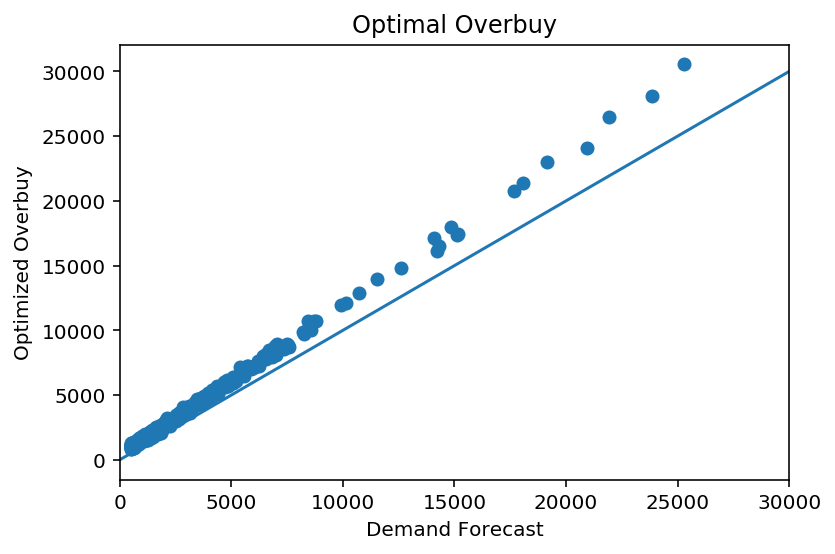

In [230]:
fig, ax = plt.subplots()
ax.scatter(t.iloc[:, 0], t.iloc[:,3])

ax.plot([0, 30000], [0, 30000])
ax.set_xlim([0, 30000])

plt.title('Optimizing Overbuy for FW20')
plt.xlabel('Demand Forecast')
plt.ylabel('Optimized Overbuy')

# Appendix

In [ ]:


# article net_demand_qty
# y = a[['net_qty', 'week']].set_index('week')

# # article category-level weekly means; set_index() for joining
# x_sport   = seasonality_sport[seasonality_sport.sports_cat_desc == a.sports_cat_desc.unique()[0]].set_index('week')
# x_rmh     = seasonality_rmh[seasonality_rmh.rmh_cat_desc == a.rmh_cat_desc.unique()[0]].set_index('week')
# x_gndr    = seasonality_gndr[seasonality_gndr.gender_desc == a.gender_desc.unique()[0]].set_index('week')
# x_agegrp  = seasonality_agegrp[seasonality_agegrp.age_group_desc == a.age_group_desc.unique()[0]].set_index('week')
# x_frnchse = seasonality_frnchse[seasonality_frnchse.franchise == a.franchise.unique()[0]].set_index('week')
# x_prdgrp  = seasonality_prdgrp[seasonality_prdgrp.prod_grp_desc == a.prod_grp_desc.unique()[0]].set_index('week')

# # design matrix (ensure 'week' alignment)
# yX = (pd.merge(y, x_sport, left_index=True, right_index=True, how = 'outer').
#       merge(x_rmh, left_index=True, right_index=True, how = 'outer').
#       merge(x_gndr, left_index=True, right_index=True, how = 'outer').
#       merge(x_agegrp, left_index=True, right_index=True, how = 'outer').
#       merge(x_frnchse, left_index=True, right_index=True, how = 'outer').
#       merge(x_prdgrp, left_index=True, right_index=True, how = 'outer').
#       drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
#            'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))

# mod = sm.OLS(yX.net_qty, yX.drop('net_qty', axis = 1), missing='drop').fit()

# ret = pd.DataFrame(index = yX.index)

# # yX.reset_index()['week'][:5]
# # ret['week'] = yX.index

# # mod.predict(yX.drop('net_qty', axis = 1)).reset_index()[:5]
# ret['seas_preds'] = mod.predict(yX.drop('net_qty', axis = 1))

# ret

# y
# yX.head()
# yX.reset_index()
# mod.predict(yX.drop('net_qty', axis = 1))

In [ ]:
### ================= ARIMAX =================

pd.DataFrame(preds)

# Subset for troubleshooting
a = np.random.choice(seasonality_dat.article_number.unique(), size = 1, replace = False)
dat_a = seasonality_dat[seasonality_dat.article_number.isin(a)]


y = dat_a[['net_qty', 'week']].set_index('week')

x_sport   = seasonality_sport[seasonality_sport.sports_cat_desc == dat_a.sports_cat_desc.unique()[0]].set_index('week')
x_rmh     = seasonality_rmh[seasonality_rmh.rmh_cat_desc == dat_a.rmh_cat_desc.unique()[0]].set_index('week')
x_gndr    = seasonality_gndr[seasonality_gndr.gender_desc == dat_a.gender_desc.unique()[0]].set_index('week')
x_agegrp  = seasonality_agegrp[seasonality_agegrp.age_group_desc == dat_a.age_group_desc.unique()[0]].set_index('week')
x_frnchse = seasonality_frnchse[seasonality_frnchse.franchise == dat_a.franchise.unique()[0]].set_index('week')
x_prdgrp  = seasonality_prdgrp[seasonality_prdgrp.prod_grp_desc == dat_a.prod_grp_desc.unique()[0]].set_index('week')

yX = (pd.merge(y, x_sport, left_index=True, right_index=True, how = 'outer').
      merge(x_rmh, left_index=True, right_index=True, how = 'outer').
      merge(x_gndr, left_index=True, right_index=True, how = 'outer').
      merge(x_agegrp, left_index=True, right_index=True, how = 'outer').
      merge(x_frnchse, left_index=True, right_index=True, how = 'outer').
      merge(x_prdgrp, left_index=True, right_index=True, how = 'outer').
      drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
           'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))

yw = dat[dat.season == 'SS19'][['year', 'week']].drop_duplicates().sort_values(['year', 'week'])

yw.loc[:,'YEAR'] = [str(x)[:-2] for x in yw.year]
yw.loc[:,'WEEK'] = [str(x)[:-2] for x in yw.week]

yw.loc[:,'date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(yw.YEAR, yw.WEEK)]

yX = (pd.merge(yX, yw[['week', 'date']], left_index=True, right_on = 'week').
      drop('week', axis = 1).
      sort_values('date').
      set_index('date'))


reg = pd.merge(
    regress(dat_a),
    yw,
    left_index=True, right_on = 'week',
).set_index('date')

reg

# yX.index

# r = pd.date_range(start=yX.index.min(), end=yX.index.max(), freq = 'W')
# r

# yX #.reindex(r) #.fillna(0.0) # .rename_axis('dt').reset_index()

arimax = sm.tsa.statespace.SARIMAX(yX.net_qty,
                                   order = (1,0,1),
                                   seasonal_order = (0,0,0,0),
                                   exog = yX.drop('net_qty', axis = 1),
                                   enforce_stationarity=False, 
                                   enforce_invertibility=False,
                                   missing = 'drop').fit()

# arimax.summary()
preds = arimax.predict()
yX = pd.merge(
    yX, 
    pd.DataFrame(preds), right_index=True, left_index=True,
)

yX.columns
yX.iloc[:,7]

numerator = ((yX.net_qty - preds) ** 2).sum()
denominator = ((yX.net_qty - np.mean(yX.net_qty)) ** 2).sum()
1 - numerator/denominator



p = pd.DataFrame(index = yX.index)
p['net_qty'] = yX.net_qty
p['preds'] = arimax.predict()
p['original'] = yX.iloc[:,7]
p.plot()

### ================= End ARIMAXperiment =================

In [ ]:
df1 = pd.DataFrame({'article': ['A', 'A', 'A', 'B', 'B', 'B', 'C', 'C'],
                     'week': [1, 2, 3, 1, 2, 3, 1, 2],
                     'cat-level': ['boy', 'boy', 'boy', 'girl', 'girl', 'girl', 'boy', 'boy']})
df2 = pd.DataFrame({'cat-level': ['boy', 'boy', 'boy', 'boy', 'girl', 'girl', 'girl', 'girl', 'girl'],
                     'week': [1, 2, 3, 4, 1, 2, 3, 4, 5]})

pd.merge(df1, df2, how = 'right').sort_values(['article', 'week'])

seasonality_dat = (
    pd.merge(seasonality_dat, seasonality_sport, how = 'left').
    merge(seasonality_rmh, how = 'left').
    merge(seasonality_gndr, how = 'left').
    merge(seasonality_agegrp, how = 'left').
    merge(seasonality_prdgrp, how = 'left').
    sort_values(['article_number', 'year', 'week']))
#  drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))


def regress(df):
    # function for regressing article net_qty on cat-level means (seasonality)
    
    df = df.copy()

    mod = sm.OLS(df.net_qty, df[['sport_weekly_mean', 'rmh_weekly_mean', 'gender_weekly_mean', 'age_weekly_mean', 'prd_grp_weekly_mean']]).fit()

    # print(df.article_number.unique(), round(mod.rsquared, 2))
    print(df.article_number.unique()[0])
    
    mods[df.article_number.unique()[0]] = mod

    ret = pd.DataFrame()
    ret['article_number'] = df.article_number
    ret['seas_preds'] = mod.predict()

    return ret

In [ ]:
# kids_jackets = pd.read_excel('data/jackets_kids.xlsx', sheet_name='FW18 art list')

dat_kj = dat0[(dat0.article_number.isin(kids_jackets['Article Number'])) & (dat0.season == 'FW18')]


In [ ]:
# -- NA check --
# seasonality_dat[pd.isnull(seasonality_dat).any(axis=1)]

In [58]:
# seasonality_dat = seasonality_dat[seasonality_dat.season_net_qty > 100].sort_values(['article_number', 'year', 'week'])
                                  # & (seasonality_dat.season.isin(['SS19', 'SS17', 'SS18']))] # CHANGE THIS FOR DELIVERY

# ref_dat = ref_dat0.copy()[['article_no', 'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc']].drop_duplicates() 

# Combine category-level means -- and -- transactions
# seasonality_dat = pd.merge(seasonality_dat, ref_dat, 
#     left_on='article_number', right_on='article_no', 
#     how = 'left'
#     ).sort_values(['article_number', 'year', 'week'])

